In [4]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) #Using this to avoid clustering in outputs
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

dataset = datasets.ImageFolder(root="cnn_dataset", transform=transforms.ToTensor()) 
train_data, test_data = random_split(dataset, [0.8, 0.2])
train_train_data, val_data = random_split(train_data, [0.8, 0.2])

trainloader = DataLoader(train_data, batch_size=8, shuffle=True)
testloader = DataLoader(test_data, batch_size=8, shuffle=True)
valdataloader = DataLoader(val_data, batch_size=8, shuffle=True)

print(type(trainloader))

<class 'torch.utils.data.dataloader.DataLoader'>


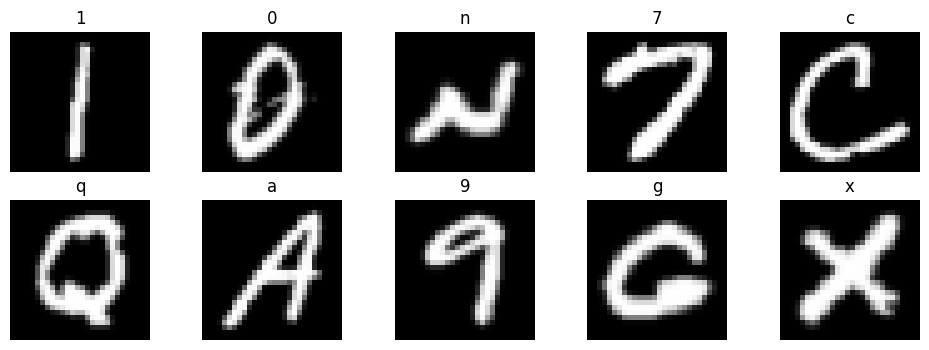

In [6]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import rgb_to_grayscale

classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

fig, axes = plt.subplots(2, 5, figsize=(12, 4))

dataloader = DataLoader(dataset)
index = 0
for row in range(2):
    for col in range(5):
        dataiter = iter(trainloader)
        train_features, train_labels = next(dataiter)
        img = rgb_to_grayscale(train_features[0]).squeeze()
        axes[row, col].imshow(img, cmap="gray")
        axes[row, col].axis('off')
        axes[row, col].set_title(classes[train_labels[0]])
        index += 1    

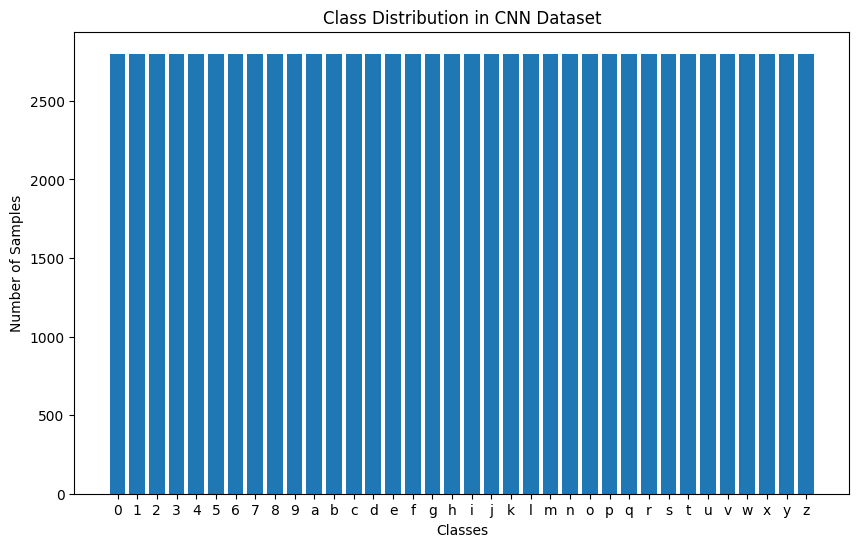

In [7]:
import os
import matplotlib.pyplot as plt


class_counts = [len(os.listdir(os.path.join("cnn_dataset", c))) for c in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in CNN Dataset')
plt.show()


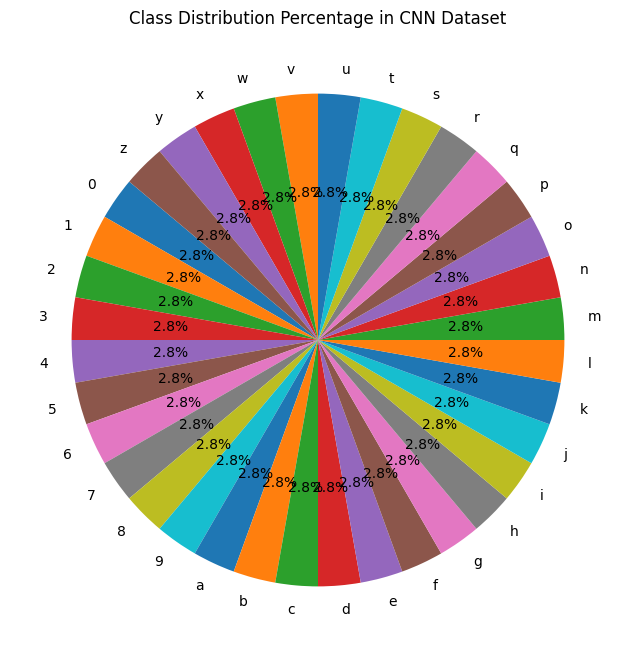

In [8]:
import os
import matplotlib.pyplot as plt

class_counts = [len(os.listdir(os.path.join("cnn_dataset", c))) for c in classes]

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=classes, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution Percentage in CNN Dataset')
plt.show()


In [4]:
import torch 
import torch.nn as nn

class CNN(nn.Module): 
    def __init__(self, dropout, activation, output_activation):
        super(CNN, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.conv = nn.Sequential(nn.Conv2d(3, 6, 5, stride=1, padding=1), activation, nn.MaxPool2d(2, 2),
                                  nn.Conv2d(6, 16, 5), activation, nn.MaxPool2d(2,2))
        self.hidden_layers = nn.Sequential(nn.Flatten(),
                                           nn.Linear(16 * 4 * 4, 400), activation, 
                                           self.dropout,
                                           nn.Linear(400, 120), activation, 
                                           nn.Linear(120, 84), activation)
        self.output_layer = nn.Linear(84, 36)
        self.output = output_activation

    def forward(self, x):
        x = self.conv(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        x = self.output(x)
        return x

model = CNN(dropout=0.05, activation=nn.ReLU(), output_activation=nn.LogSoftmax()) 

In [5]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Dropout: 1-1                           --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-1                       456
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       2,416
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       102,800
│    └─ReLU: 2-9                         --
│    └─Dropout: 2-10                     --
│    └─Linear: 2-11                      48,120
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      10,164
│    └─ReLU: 2-14                        --
├─Linear: 1-4                            3,060
├─LogSoftmax: 1-5                        --
Total params: 167,016
Trainable params: 167,016
Non

In [6]:
import torch.optim as optim

model = CNN(dropout=0.05, activation=nn.ReLU(), output_activation=nn.LogSoftmax()) 

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0015, momentum=0.9)

In [7]:
print(len(trainloader))
print(len(valdataloader))
print(len(testloader))

10080
2016
2520


In [8]:
def return_accuracy():
    None

In [9]:
train_losses = []
validation_losses = []
test_losses = []

train_accuracies = []
validation_accuracies = []
test_accuracies = []

import time
start_time = time.time()
print("Start Time: ", start_time)
print()
best_val_accuracy = 0
best_model = None
counter = 0
early_stop = 3
for epoch in range(10):
    print("Epoch: ", epoch + 1)
    #Training
    print("Training.")
    predictions_arr = []
    labels_arr = []
    train_loss = 0
    train_accuracy = 0
    count = 1
    acc_count = 0
    correct_pred = 0
    for data in trainloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predictions = torch.max(outputs.data, 1)
        acc_count += len(predictions)
        for x, y in zip(predictions, labels):
            predictions_arr.append(x)
            labels_arr.append(y)
            if x == y:
                correct_pred += 1
        if count % 2000 == 0:
            train_losses.append(train_loss/(len(trainloader)/8))
            # print(train_loss/(len(trainloader)/8))
            train_loss = 0
        count += 1
    train_accuracies.append((correct_pred/acc_count))

    #Validation
    print("Validating..")
    validation_loss = 0
    validation_accuracy = 0
    count = 1
    predictions_arr = []
    labels_arr = []
    correct_pred = 0
    acc_count = 0
    with torch.no_grad():
        for data in valdataloader:
            images, labels = data
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.step()
            validation_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            acc_count += len(predictions)
            for x, y in zip(predictions, labels):
                predictions_arr.append(x)
                labels_arr.append(y)
                if x == y:
                    correct_pred += 1
            if count % 400 == 0:
                validation_losses.append(validation_loss/(len(valdataloader)/8))
                # print(train_loss/(len(trainloader)/8))
                validation_loss = 0
            count +=1
        validation_accuracy = correct_pred/acc_count
        validation_accuracies.append(validation_accuracy)
    
    if validation_accuracy - best_val_accuracy > 1:
        best_val_accuracy = validation_accuracy
        best_model = model
        counter = 0
    else:
        counter += 1
    
    #Testing
    print("Testing...")
    count = 1
    predictions_arr = []
    labels_arr = []
    test_loss = 0
    acc_count = 0
    correct_pred = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.step()
            test_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            for x, y in zip(predictions, labels):
                predictions_arr.append(x)
                labels_arr.append(y)
                if x == y:
                    correct_pred += 1
            acc_count += len(predictions)
            if count % 500 == 0:
                test_losses.append(test_loss/(len(testloader)/8))
                # print(test_loss/(len(testloader)/8))
                test_loss = 0
            count += 1
        test_accuracies.append((correct_pred/(acc_count)))
    print()
    if early_stop != None and counter > early_stop:
        break

end_time = time.time()
print("End Time: ", start_time)
print("Train time: ", end_time - start_time)
print(count)

Start Time:  1699900388.4635332

Epoch:  1
Training.
Validating..
Testing...

Epoch:  2
Training.
Validating..
Testing...

Epoch:  3
Training.
Validating..
Testing...

Epoch:  4
Training.
Validating..
Testing...

End Time:  1699900388.4635332
Train time:  773.7346408367157
2521


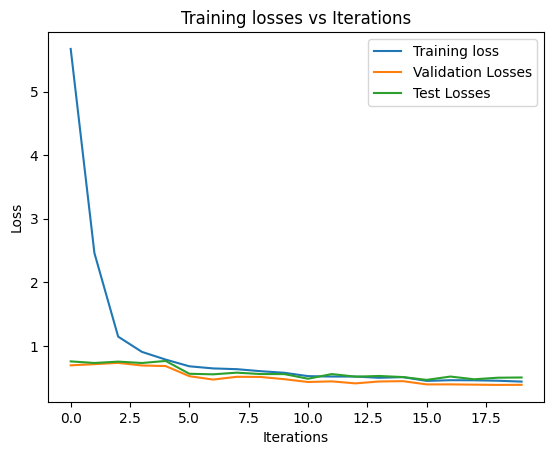

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label="Validation Losses")
plt.plot(test_losses, label="Test Losses")
plt.title('Training losses vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

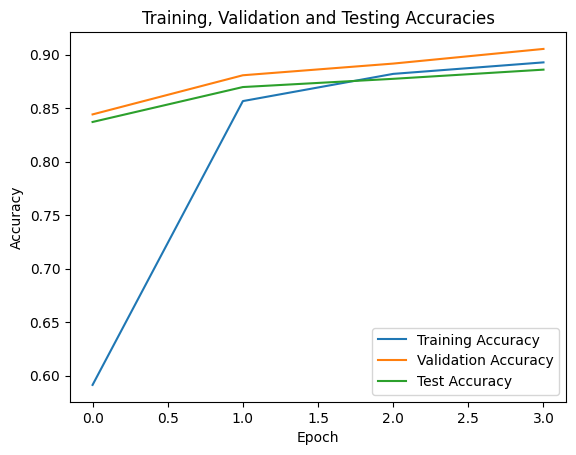

In [11]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training, Validation and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
correct_pred = 0
count = 0
predictions_arr = []
labels_arr = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs.data, 1)
        for x, y in zip(predictions, labels):
            predictions_arr.append(x)
            labels_arr.append(y)
            if x == y:
                correct_pred += 1
        count += len(predictions)

print(f'Test Accuracy:', (correct_pred/count)*100)

Test Accuracy: 88.56150793650794


In [13]:
predicted_labels = []
true_labels = []
for x in predictions_arr:
    predicted_labels.append(classes[x.item()])

for x in labels_arr:
    true_labels.append(classes[x.item()])

print(predicted_labels)
print(true_labels)

['i', '1', '5', '2', '9', 'y', '1', 'b', '3', 'r', 'y', 'x', 't', 'x', 's', 'g', 'b', '6', 't', '9', '2', 'a', 'z', '1', '0', 'q', 'y', 'f', 'y', 'a', 't', '9', 'n', 'b', 'm', '1', '2', 'g', 'd', 'i', 'a', 'u', 'o', '6', 'h', 'v', 'f', 'm', 'c', 'w', '1', '6', '3', '8', 'm', '4', 'd', 'i', 'l', 'c', 'f', 'b', '7', 'e', '3', '7', 'c', 'h', '3', 'n', 'i', '9', '9', 'p', 't', '6', '4', 't', 'k', 'b', 'f', 'w', 'v', '7', '4', '2', 'c', 'i', '7', 't', 'w', '0', 'v', 'a', '1', 'd', 'c', 'e', '4', 'z', 'o', 'z', 'i', '5', '7', 'a', '3', 'q', '6', 'o', '4', 'm', 'c', 'm', 'u', '1', '0', 't', 'w', 'e', 'c', 'd', 'n', 'b', '6', 'i', 'w', '5', 'm', '6', '0', 'w', '1', 'n', 'w', 'y', '8', 's', 'c', 'j', 'i', 'q', '2', 'h', '7', 'a', 'k', 'y', 'j', 'd', 'c', '8', 'n', '1', 'e', 'i', '4', '6', '8', 'r', 'j', 'v', 'k', 'y', 'e', 'a', 'v', '8', 'j', 'z', '6', 'm', 'u', 'c', 'p', '7', 'x', 'x', 'b', '6', 'w', 's', 'q', 'g', 'm', '0', 'w', '0', 'j', 'e', 'n', 'v', 'i', '0', 'c', '5', 'm', 'e', 'z', '1',

In [14]:
from sklearn.metrics import precision_recall_fscore_support
print(type(predictions_arr))
print(type(labels_arr))
precision, recall, fscore, support = precision_recall_fscore_support(y_true=labels_arr, y_pred=predictions_arr, average='macro')
print("Precision:", precision, "\nRecall: ", recall, "\nF-Score: ", fscore, "\nSupport: ", support)

<class 'list'>
<class 'list'>
Precision: 0.901402567598535 
Recall:  0.8860329955131612 
F-Score:  0.8814255663881939 
Support:  None


In [15]:
torch.save(model.state_dict(), "cnn_weights.pth")

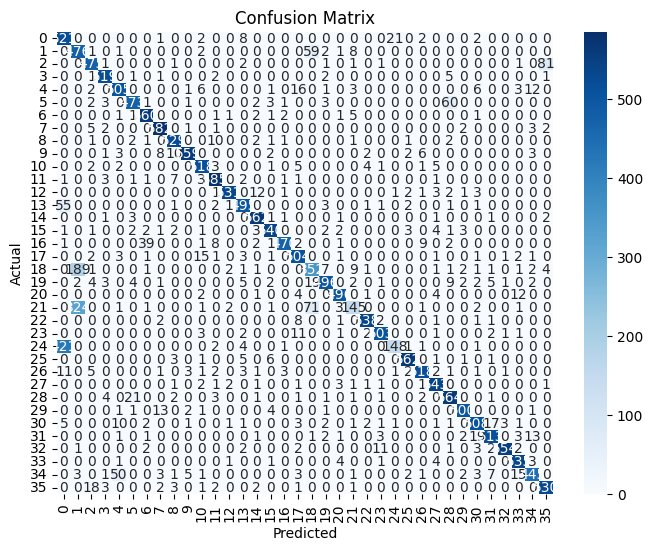

In [16]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

confusion_mat = confusion_matrix(true_labels, predicted_labels)

class_names = [str(i) for i in range(len(np.unique(predictions_arr)))]

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


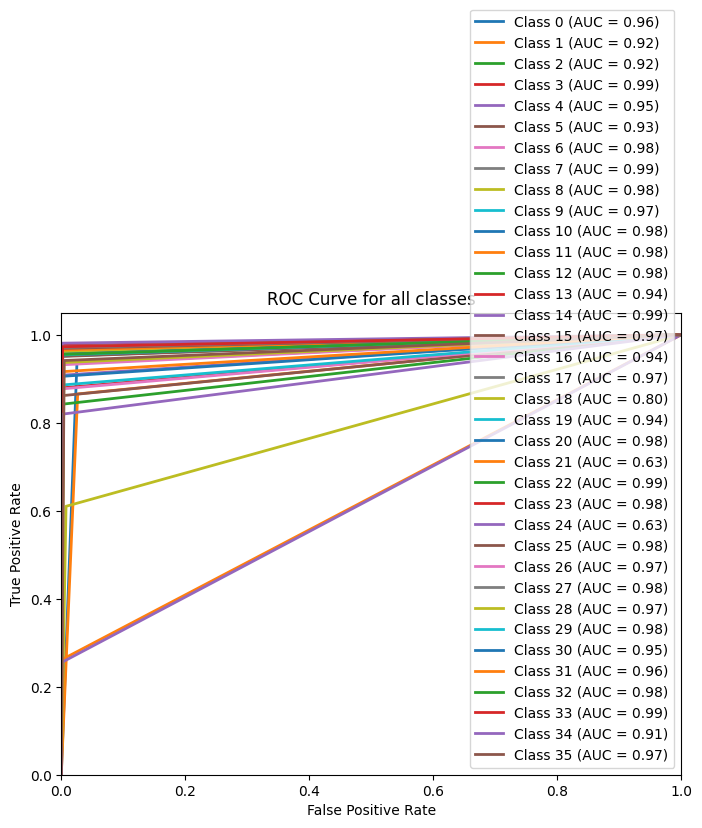

In [17]:
from sklearn.metrics import roc_curve, auc
roc_data = {}

predicted_labels = np.array(predictions_arr)

num_classes = len(np.unique(predictions_arr))

for class_index in range(num_classes): 
    binary_true_labels = [1 if label == class_index else 0 for label in labels_arr]
    
    fpr, tpr, _ = roc_curve(binary_true_labels, predicted_labels == class_index)
    roc_auc = auc(fpr, tpr)
    
    roc_data[class_index] = (fpr, tpr, roc_auc)


plt.figure(figsize=(8, 6))
for class_index in range(num_classes):
    fpr, tpr, roc_auc = roc_data[class_index]
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_index} (AUC = {roc_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all classes')
plt.legend(loc='lower right')
plt.show()

References


In [18]:
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
#https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders
#https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
#https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
#https://pytorch.org/docs/stable/optim.html